# **Brain Tumor Classification Using Pytorch Libraries.**
Notebook by *Sudarshan Chikkathimmaiah*

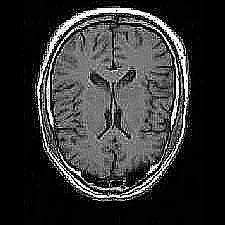

Brain tumor classification is a critical task in medical imaging that aids in the early detection and diagnosis of various types of brain tumors. This project focuses on developing a deep learning model using PyTorch to accurately classify brain tumor images into different categories based on their characteristics.

## **1. Import all the necessary libraries.**

In [1]:
import numpy as np
import torch
import torchvision
from torchvision import models, transforms
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split,DataLoader
import timm
from torch import nn
from tqdm.auto import tqdm
from typing import Dict, List, Tuple
from PIL import Image
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import MultiStepLR
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch.onnx
import time

from google.colab import drive
drive.mount('/content/gdrive')

%matplotlib inline

Mounted at /content/gdrive


## **2. Data Preprocessing.**


In [2]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
])

dataset = ImageFolder(root='/content/gdrive/MyDrive/brain_tumor_mri_scans', transform=transform)

# Set the split ratio (e.g., 80% train, 20% test)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# Split the dataset
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=32,num_workers=4, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32,num_workers=4, shuffle=True)

print(f"Total images: {len(dataset)}")
print(f"Training images: {len(train_dataset)}")
print(f"Testing images: {len(test_dataset)}")
print(f"Number of classes: {len(dataset.classes)}")
print(f"Class names: {dataset.classes}")

Total images: 7023
Training images: 5618
Testing images: 1405
Number of classes: 4
Class names: ['glioma', 'healthy', 'meningioma', 'pituitary']


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## **3. Visualize Dataset**

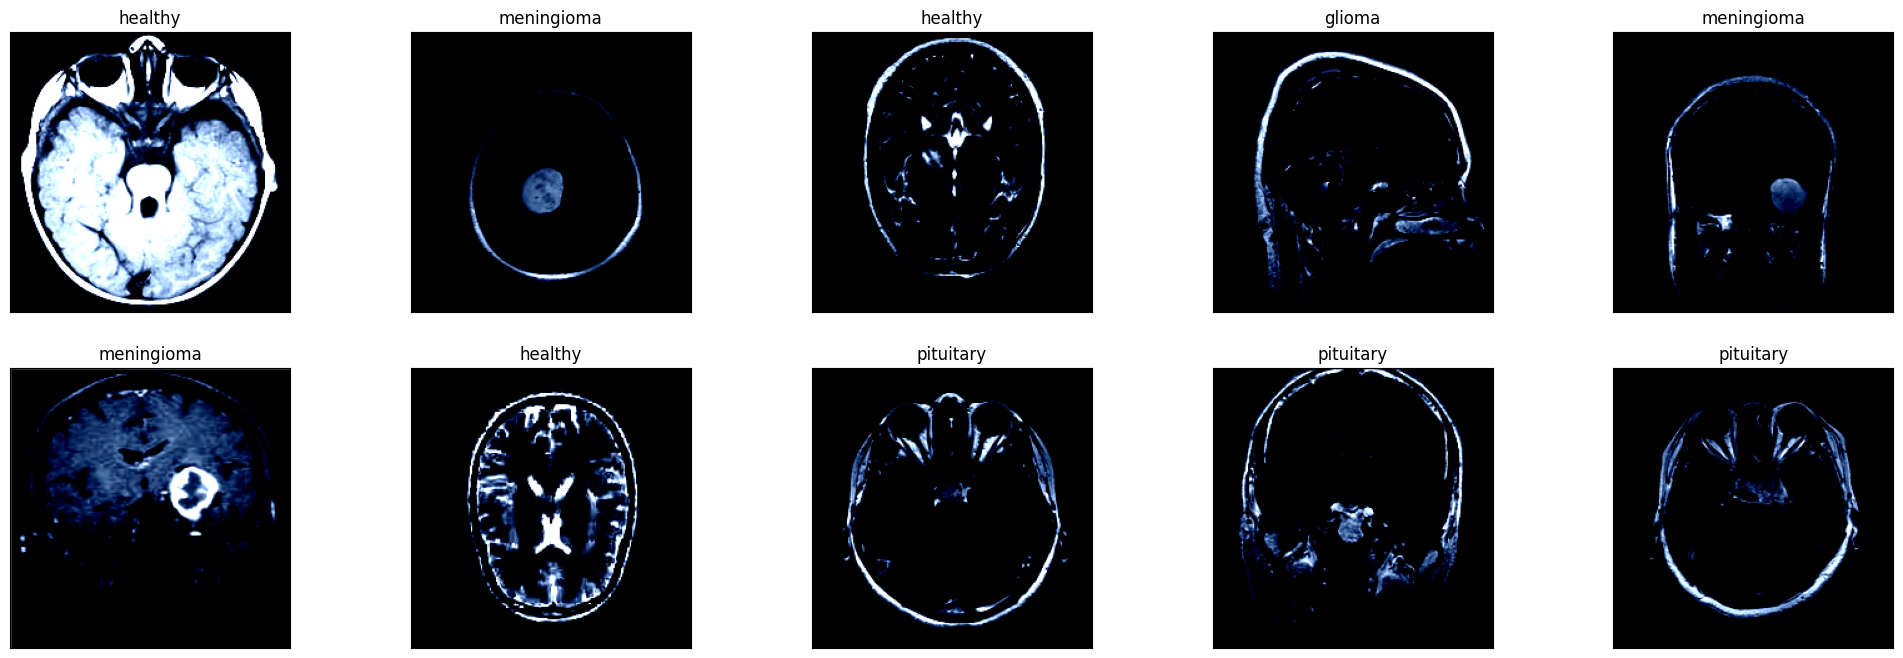

In [3]:
dataiter = iter(train_dataloader)
images, labels = next(dataiter)
images = images.numpy()
fig = plt.figure(figsize=(25, 8))
for idx in np.arange(10):
    ax = fig.add_subplot(2, int(10/2), idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(dataset.classes[labels[idx]])

## **4. Model Version 1 training and testing.**

### **1. Create model using TIMM and modify the model for training.**

In [4]:
m = timm.create_model('resnet10t', pretrained=True, exportable=True)
print(f'Original pooling: {m.global_pool}')
print(f'Original classifier: {m.get_classifier()}')
print('--------------------')

m.reset_classifier(4, 'max')
print(f'Modified pooling: {m.global_pool}')
print(f'Modified classifier: {m.get_classifier()}')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.8M [00:00<?, ?B/s]

Original pooling: SelectAdaptivePool2d(pool_type=avg, flatten=Flatten(start_dim=1, end_dim=-1))
Original classifier: Linear(in_features=512, out_features=1000, bias=True)
--------------------
Modified pooling: SelectAdaptivePool2d(pool_type=max, flatten=Flatten(start_dim=1, end_dim=-1))
Modified classifier: Linear(in_features=512, out_features=4, bias=True)


### **2. Design Fully Connected Layer.**

**i. Design model layers.**

Define number of input features for the classifier and design the fully connected layer with linear network, normalization, activation function and a dropout layer.

In [5]:
num_in_features = m.get_classifier().in_features
m.fc = nn.Sequential(
    nn.BatchNorm1d(num_in_features),
    nn.Linear(in_features=num_in_features, out_features=512, bias=False),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Dropout(0.4),
    nn.Linear(in_features=512, out_features=4, bias=False))

**ii. Define Loss Function, Optimizer and Scheduler**

In [6]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(m.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

### **3. Move to GPUs.**

In [7]:
if torch.cuda.is_available():
    device = torch.device('cuda')  # CUDA GPU
elif torch.backends.mps.is_available():
    device = torch.device('mps') #Apple GPU
else:
    device = torch.device("cpu")

device

device(type='cuda')

### **4. Model Training and Testing.**

In [8]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               scheduler: torch.optim.lr_scheduler,
               device: torch.device) -> Tuple[float, float]:
    """Trains a PyTorch model for a single epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).

    Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
    """
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)


    return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    """Tests a PyTorch model for a single epoch.

    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.

    Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
    """
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          scheduler: torch.optim.lr_scheduler,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]}
    For example if training for epochs=2:
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]}
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                           scheduler=scheduler,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        scheduler.step()

    # Return the filled results at the end of the epochs
    return results


In [9]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = train(model=m,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                        scheduler=scheduler,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2635 | train_acc: 0.9047 | test_loss: 0.1442 | test_acc: 0.9523
Epoch: 2 | train_loss: 0.0873 | train_acc: 0.9707 | test_loss: 0.4238 | test_acc: 0.8771
Epoch: 3 | train_loss: 0.0704 | train_acc: 0.9746 | test_loss: 0.0875 | test_acc: 0.9694
Epoch: 4 | train_loss: 0.0479 | train_acc: 0.9840 | test_loss: 0.2579 | test_acc: 0.9317
Epoch: 5 | train_loss: 0.0551 | train_acc: 0.9812 | test_loss: 0.0576 | test_acc: 0.9808
[INFO] Total training time: 720.486 seconds


### **5. Plot Accuracy and Loss curves.**

In [10]:
# Plot loss curves of a model
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

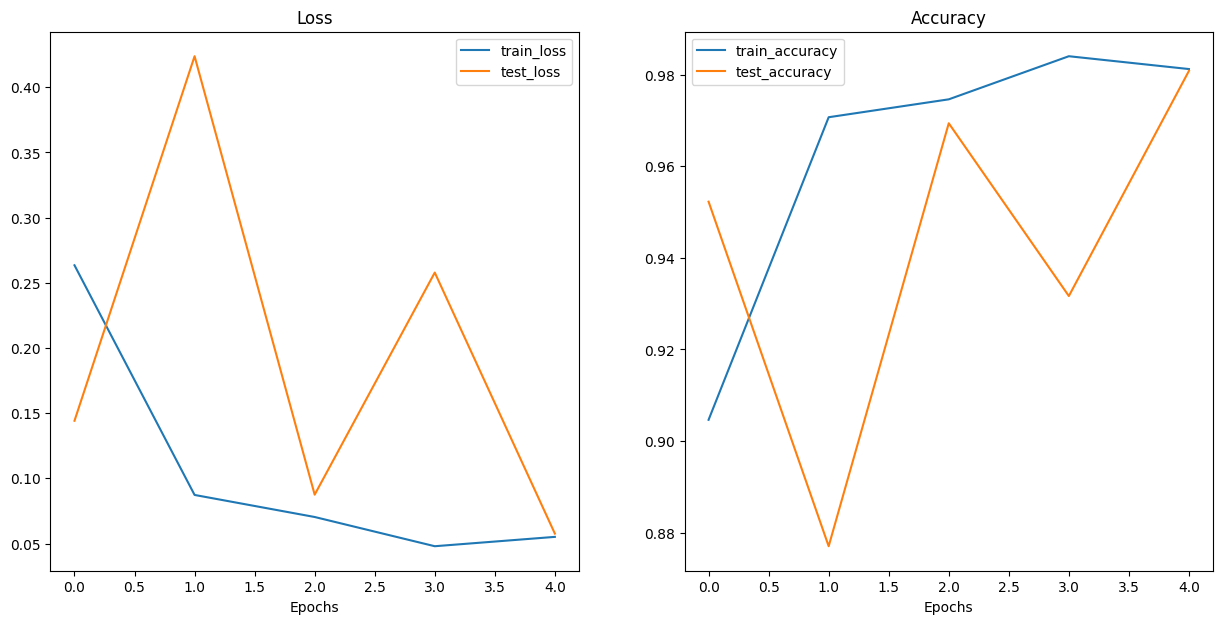

In [11]:
plot_loss_curves(results)

### **6. Test on custom data.**

In [12]:
# 1. Take in a trained model, class names, image path, image size, a transform and target device
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):


    # 2. Open image
    img = Image.open(image_path)

    # 3. Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    ### Predict on image ###

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
      # 6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
      transformed_image = image_transform(img).unsqueeze(dim=0)

      # 7. Make a prediction on image with an extra dimension and send it to the target device
      target_image_pred = model(transformed_image.to(device))

    # 8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 10. Plot image with predicted label and probability
    plt.figure()
    plt.imshow(img)

    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);

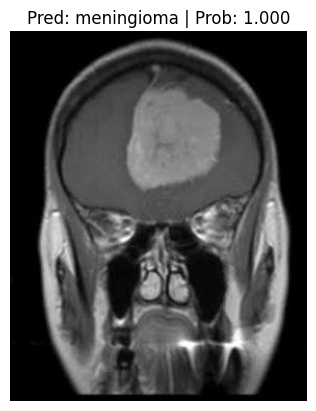

In [14]:
custom_image_path="/content/gdrive/MyDrive/brain_tumor_mri_scans/meningioma/0010.jpg"
pred_and_plot_image(model=m,
                    image_path=custom_image_path,
                    class_names=dataset.classes)

### **7. Plot Confusion matrix.**

In [15]:
def get_predictions(model, iterator):
    model.eval()
    images = []
    labels = []
    probs = []

    with torch.no_grad():
        for (x, y) in iterator:
            x = x.to(device)
            y_pred = model(x)

            y_prob = F.softmax(y_pred, dim=-1)
            top_pred = y_prob.argmax(1, keepdim=True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs

In [16]:
images, labels, probs = get_predictions(m, test_dataloader)

In [17]:
pred_labels = torch.argmax(probs, 1)

In [18]:
# from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
# def plot_confusion_matrix(labels, pred_labels, classes):

#     fig = plt.figure(figsize = (50, 50))
#     ax = fig.add_subplot(1, 1, 1)
#     cm = confusion_matrix(labels, pred_labels)
#     cm = ConfusionMatrixDisplay(cm, display_labels = classes)
#     cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
#     fig.delaxes(fig.axes[1])
#     plt.yticks(fontsize = 25)
#     plt.xticks(rotation = 90, fontsize = 25)
#     plt.xlabel('Predicted Label', fontsize = 50)
#     plt.ylabel('True Label', fontsize = 50)

def plot_confusion_matrix(labels, pred_labels, classes, values_font_size=25):
    fig = plt.figure(figsize=(50, 50))
    ax = fig.add_subplot(1, 1, 1)
    cm = confusion_matrix(labels, pred_labels)
    disp = ConfusionMatrixDisplay(cm, display_labels=classes)
    disp.plot(values_format='d', cmap='Blues', ax=ax)

    # Modify font size of the values inside the matrix
    for text in disp.text_.ravel():
        text.set_fontsize(values_font_size)

    fig.delaxes(fig.axes[1])
    plt.yticks(fontsize=25)
    plt.xticks(rotation=90, fontsize=25)
    plt.xlabel('Predicted Label', fontsize=50)
    plt.ylabel('True Label', fontsize=50)
    plt.title('Confusion Matrix', fontsize=60)

    # return fig

# Usage
# fig = plot_confusion_matrix(labels, pred_labels, classes, values_font_size=30)
# plt.show()

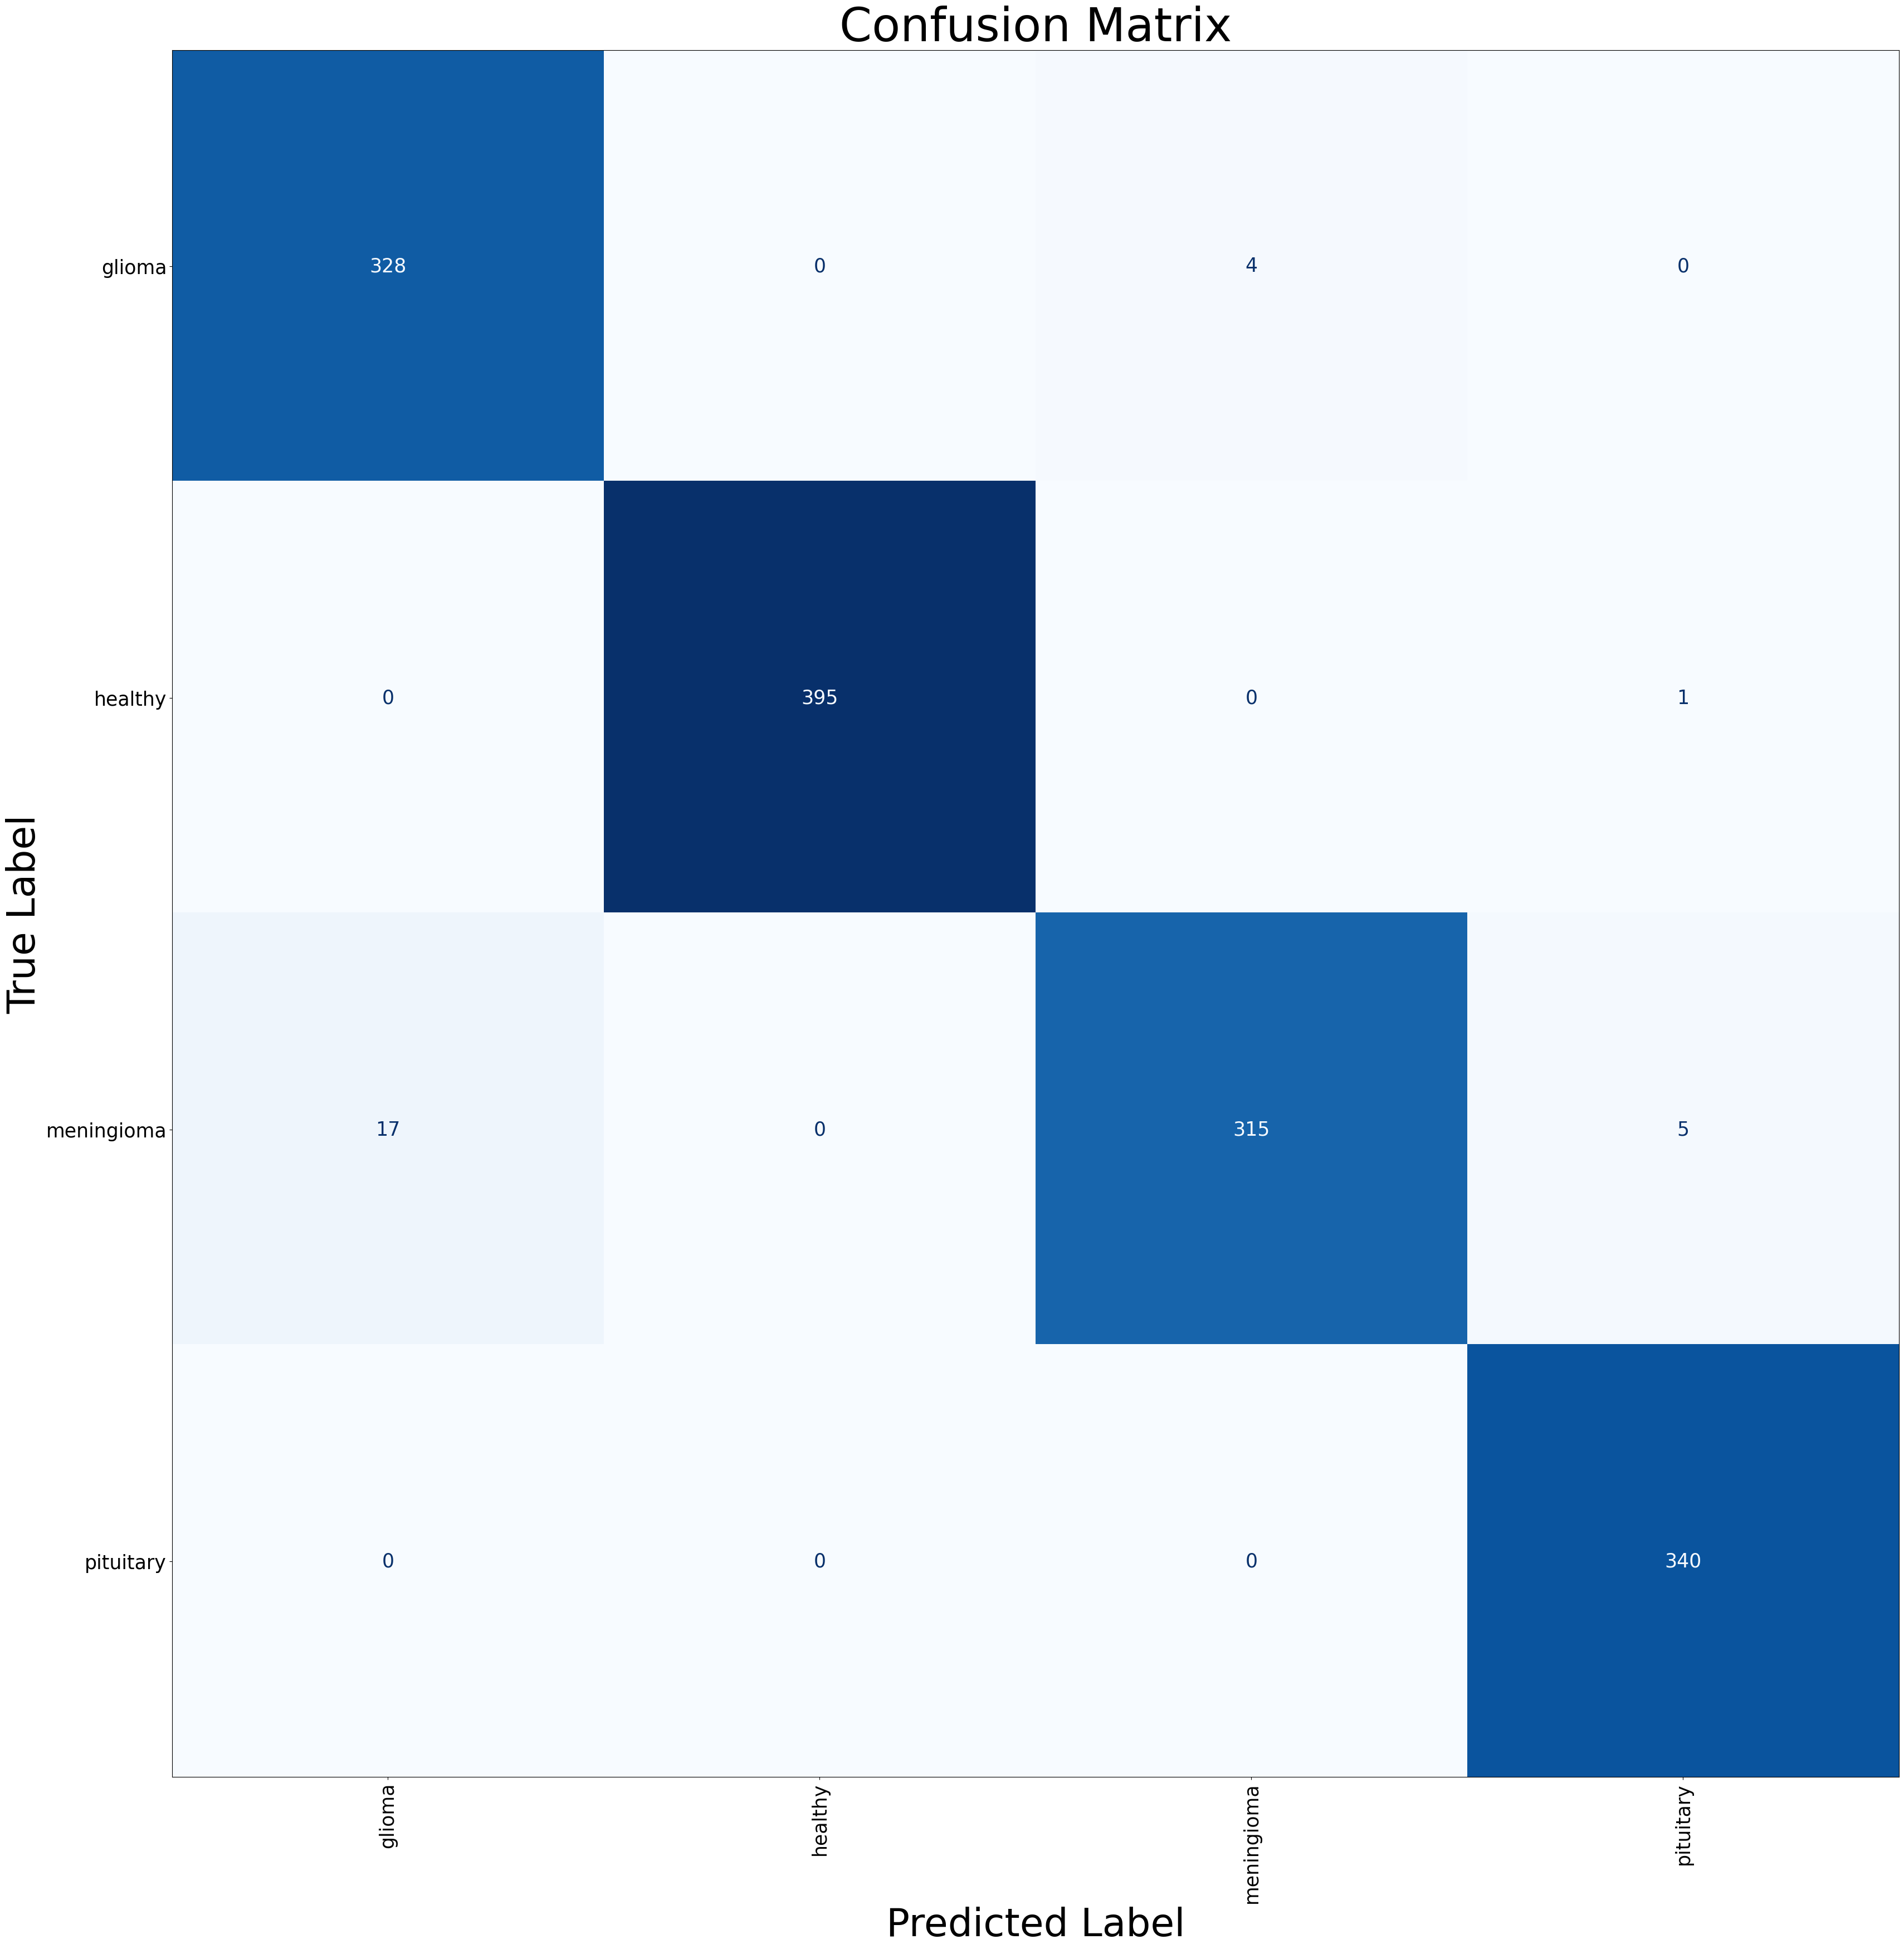

In [19]:
plot_confusion_matrix(labels, pred_labels, dataset.classes)

### **8. Save Model Version.**

In [22]:
device = next(m.parameters()).device  # Get the device of the model
m1 = m.to(device)  # Ensure model is on this device (redundant if already there)
dummy_input = torch.randn(1, 3, 224, 224).to(device)

# Export the model
torch.onnx.export(m,               # model being run
                  dummy_input,         # model input (or a tuple for multiple inputs)
                  "model_v1.onnx",        # where to save the model
                  export_params=True,  # store the trained parameter weights inside the model file
                  opset_version=10,    # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                'output' : {0 : 'batch_size'}})
print("Model Saved!")

Model Saved!


### **9. Perform Inference Optimization.**

In [23]:
def measure_inference_time(model, input_tensor, num_runs=100):
    start_time = time.time()
    with torch.no_grad():
        for _ in range(num_runs):
            _ = model(input_tensor)
    end_time = time.time()
    return (end_time - start_time) / num_runs

# Baseline inference time
print("Baseline Model:")
baseline_time = measure_inference_time(m, dummy_input)
print(f"Average inference time: {baseline_time:.4f} seconds")

scripted_model = torch.jit.script(m)
print("\nTorchScript Model:")
script_time = measure_inference_time(scripted_model, dummy_input)
print(f"Average inference time: {script_time:.4f} seconds")
print(f"Speedup: {baseline_time / script_time:.2f}x")

Baseline Model:
Average inference time: 0.0063 seconds

TorchScript Model:
Average inference time: 0.0066 seconds
Speedup: 0.96x


## **5. Model Version 2 training and testing.**

### **1. Create model using TIMM.**

In [24]:
m1 = timm.create_model('resnet10t', pretrained=True)

print(f'Original pooling: {m1.global_pool}')
print(f'Original classifier: {m1.get_classifier()}')
print('--------------------')

m1.reset_classifier(4, 'max')

print(f'Modified pooling: {m1.global_pool}')
print(f'Modified classifier: {m1.get_classifier()}')

Original pooling: SelectAdaptivePool2d(pool_type=avg, flatten=Flatten(start_dim=1, end_dim=-1))
Original classifier: Linear(in_features=512, out_features=1000, bias=True)
--------------------
Modified pooling: SelectAdaptivePool2d(pool_type=max, flatten=Flatten(start_dim=1, end_dim=-1))
Modified classifier: Linear(in_features=512, out_features=4, bias=True)


### **2. Design Fully Connected Layer.**

In [25]:
num_in_features_m1 = m1.get_classifier().in_features
m1.fc = nn.Sequential(
    nn.BatchNorm1d(num_in_features_m1),
    nn.Linear(in_features=num_in_features_m1, out_features=512, bias=False),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Dropout(0.4),
    nn.Linear(in_features=512, out_features=4, bias=False))

In [26]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(m1.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
milestones = [30, 60, 90]
scheduler = MultiStepLR(optimizer, milestones=milestones, gamma=0.1)

### **3. Model Training and Testing.**

In [27]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = train(model=m1,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       scheduler=scheduler,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch: 1 | train_loss: 0.4146 | train_acc: 0.8613 | test_loss: 0.5486 | test_acc: 0.8057
Epoch: 2 | train_loss: 0.1837 | train_acc: 0.9390 | test_loss: 0.1545 | test_acc: 0.9467
Epoch: 3 | train_loss: 0.0805 | train_acc: 0.9730 | test_loss: 0.1043 | test_acc: 0.9659
Epoch: 4 | train_loss: 0.0422 | train_acc: 0.9863 | test_loss: 0.0966 | test_acc: 0.9673
Epoch: 5 | train_loss: 0.0369 | train_acc: 0.9874 | test_loss: 0.0457 | test_acc: 0.9836
[INFO] Total training time: 249.793 seconds


### **4. Plot Accuracy and Loss curves.**

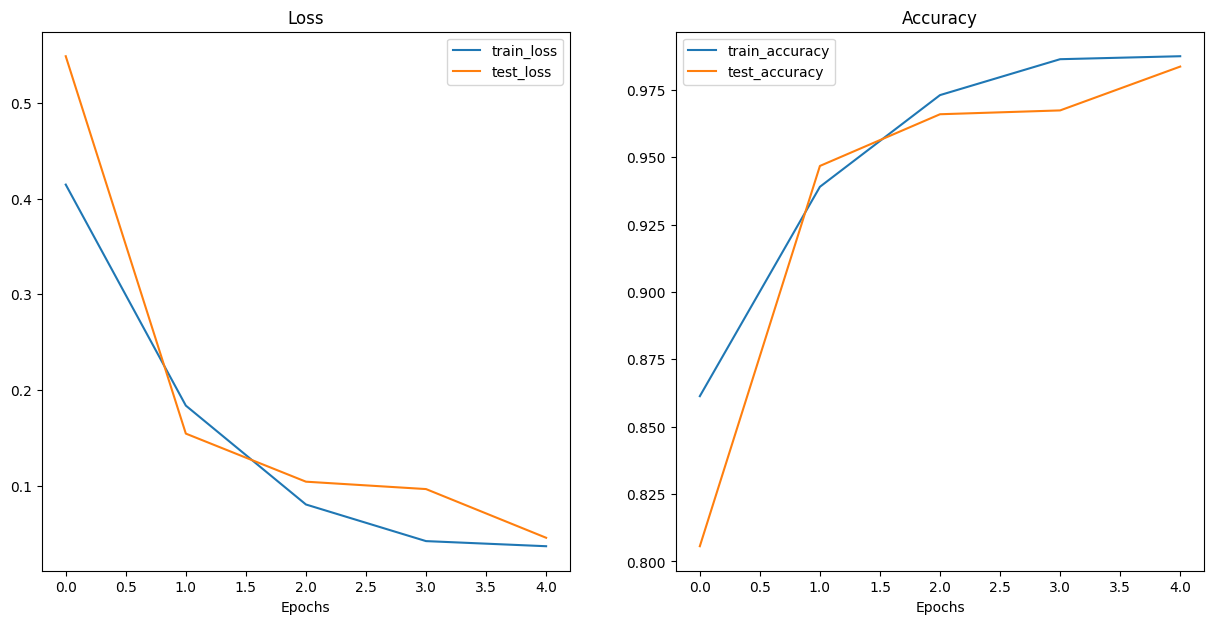

In [33]:
plot_loss_curves(results)

### **5. Plot confusion matrix.**

In [28]:
images, labels, probs = get_predictions(m1, test_dataloader)

In [29]:
pred_labels = torch.argmax(probs, 1)

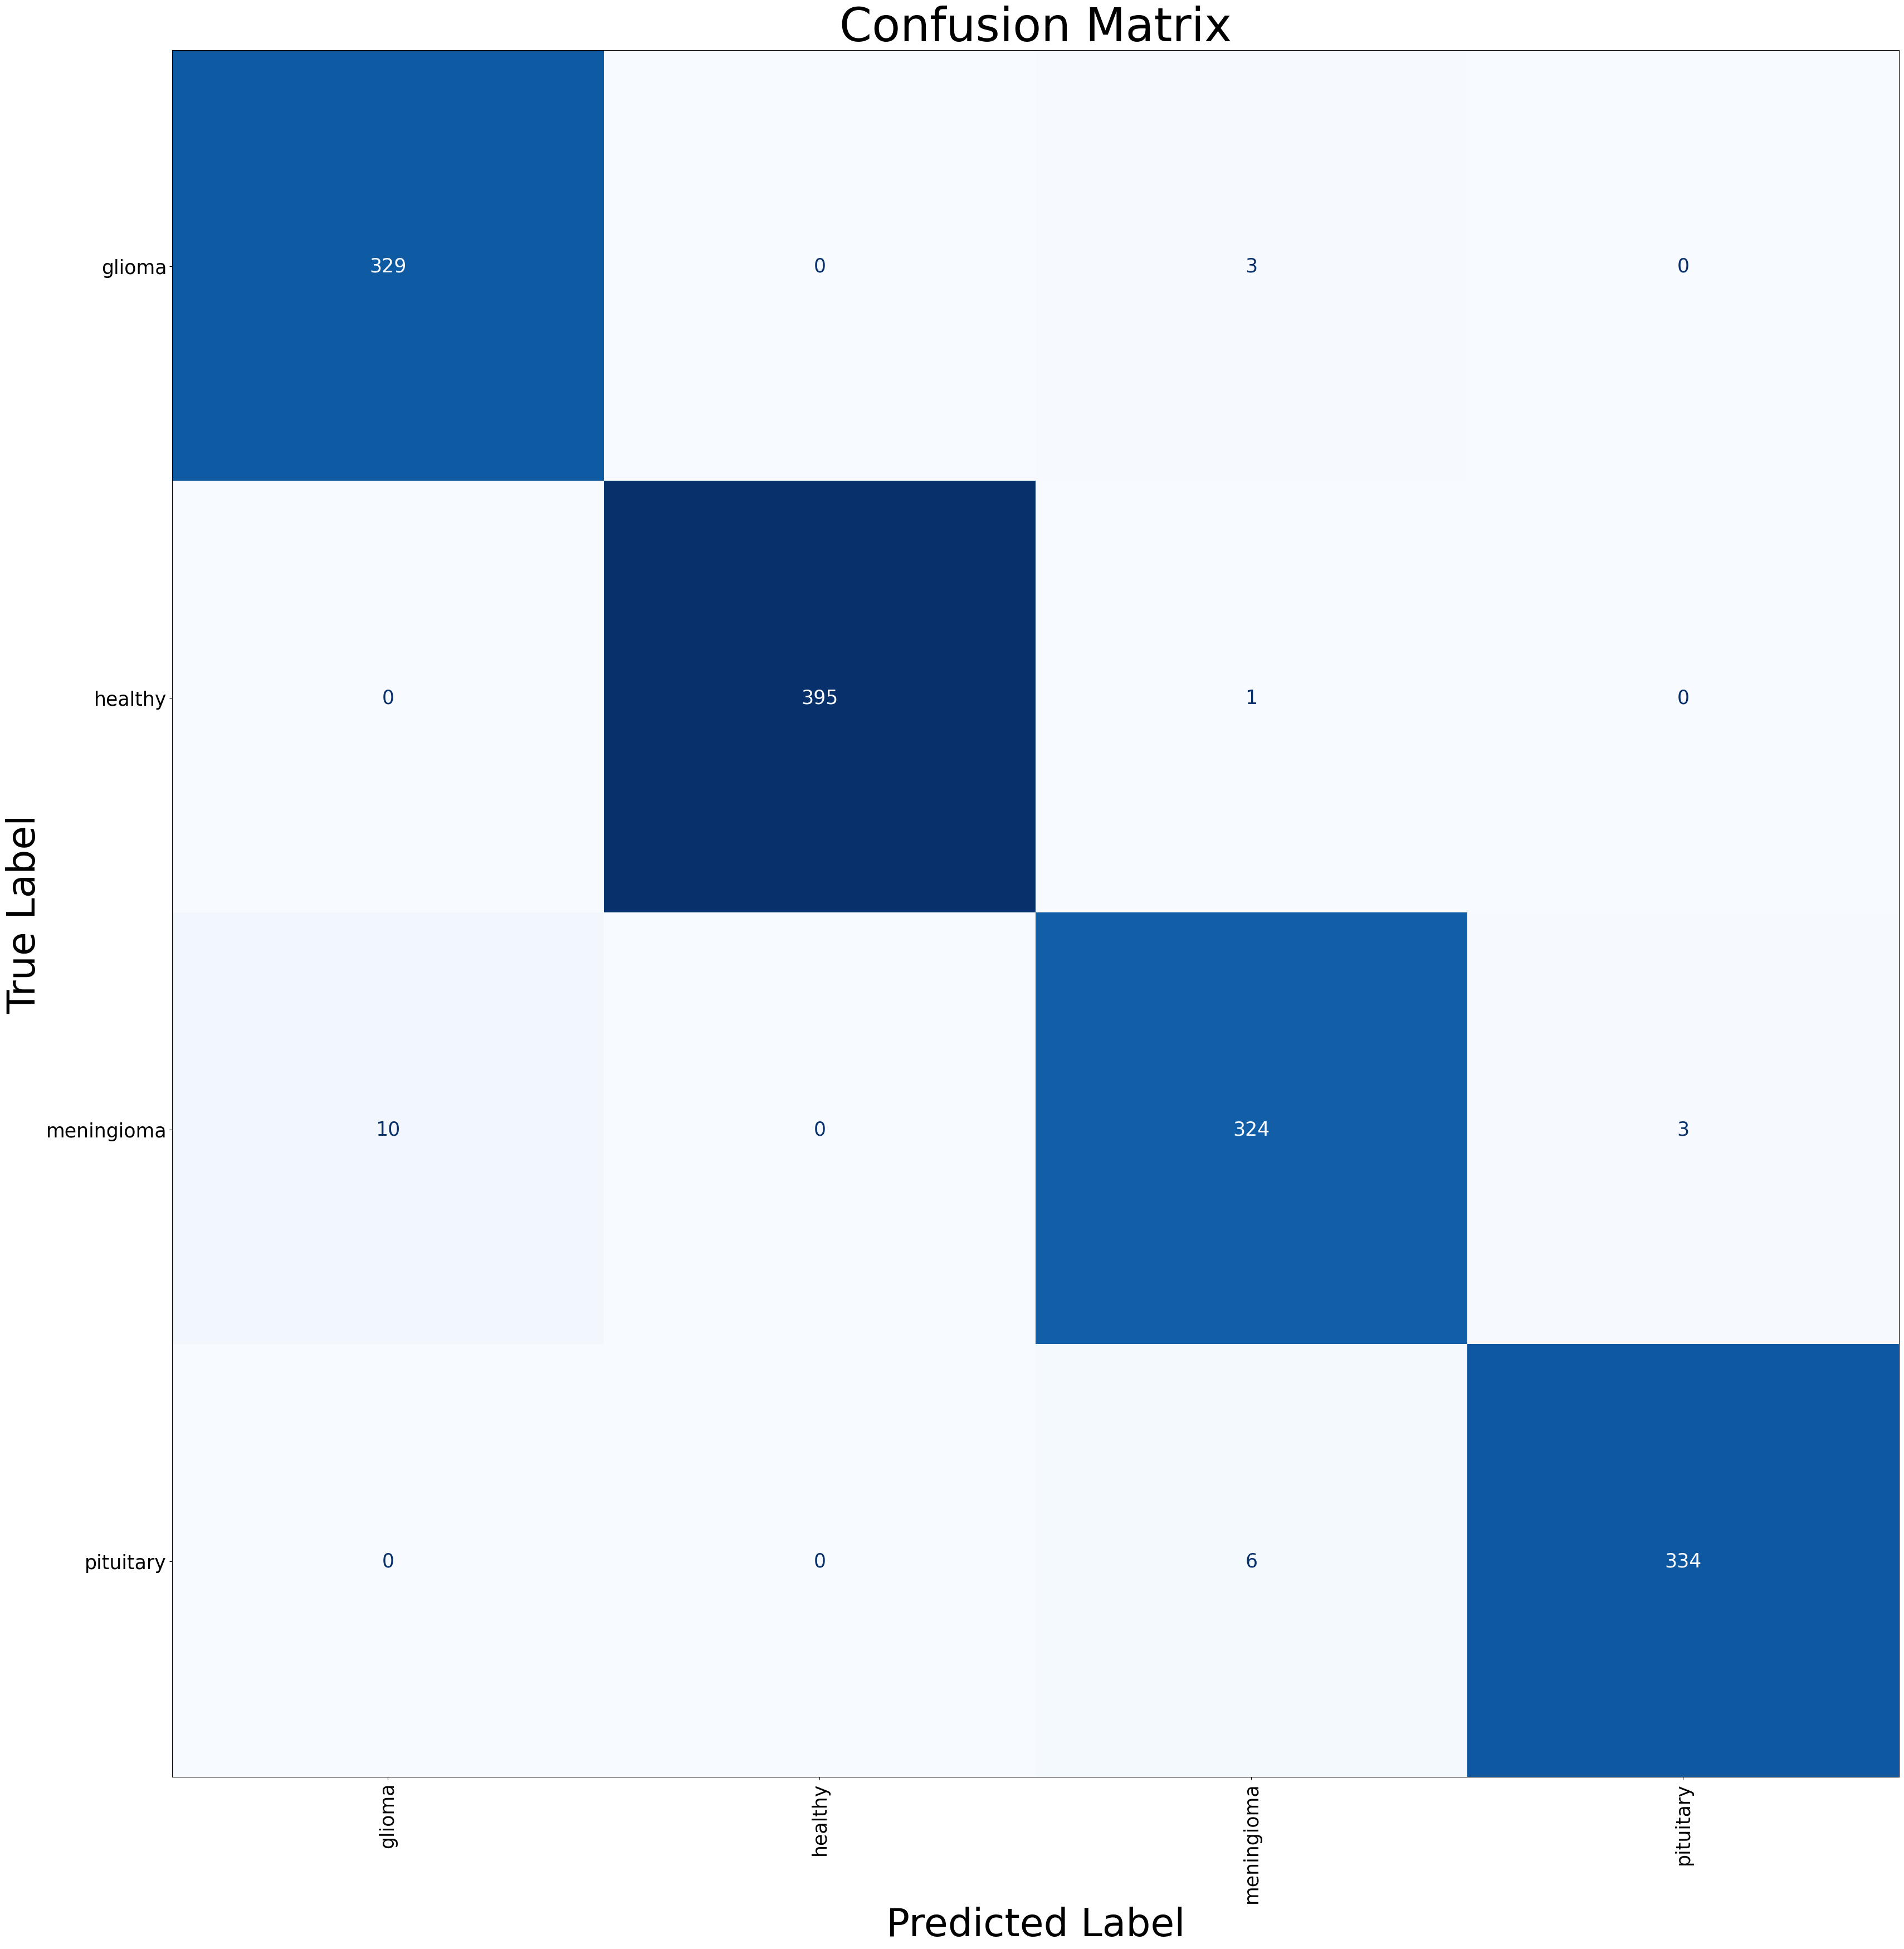

In [30]:
plot_confusion_matrix(labels, pred_labels, dataset.classes)

### **6. Save Model Version.**

In [31]:
device = next(m1.parameters()).device  # Get the device of the model
m1 = m1.to(device)  # Ensure model is on this device (redundant if already there)
dummy_input = torch.randn(1, 3, 224, 224).to(device)

# Export the model
torch.onnx.export(m1,               # model being run
                  dummy_input,         # model input (or a tuple for multiple inputs)
                  "model_v2.onnx",        # where to save the model
                  export_params=True,  # store the trained parameter weights inside the model file
                  opset_version=10,    # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                'output' : {0 : 'batch_size'}})
print("Model Saved!")

Model Saved!


### **7. Perform Inference Optimization.**

In [32]:
def measure_inference_time(model, input_tensor, num_runs=100):
    start_time = time.time()
    with torch.no_grad():
        for _ in range(num_runs):
            _ = model(input_tensor)
    end_time = time.time()
    return (end_time - start_time) / num_runs

# Baseline inference time
print("Baseline Model:")
baseline_time = measure_inference_time(m1, dummy_input)
print(f"Average inference time: {baseline_time:.4f} seconds")

scripted_model = torch.jit.script(m1)
print("\nTorchScript Model:")
script_time = measure_inference_time(scripted_model, dummy_input)
print(f"Average inference time: {script_time:.4f} seconds")
print(f"Speedup: {baseline_time / script_time:.2f}x")

Baseline Model:
Average inference time: 0.0032 seconds

TorchScript Model:
Average inference time: 0.0029 seconds
Speedup: 1.11x
